## Shubham Shekhar Jha
## CS6320 - NLP - HW4


Download the [Kaggle Dataset](https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification) also available at this [open zenodo link](https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification)


In [1]:
!wget https://zenodo.org/records/3355823/files/ecommerceDataset.csv?download=1 -O ecommerceDataset.csv

--2024-04-04 01:44:25--  https://zenodo.org/records/3355823/files/ecommerceDataset.csv?download=1
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.185.79.172, 188.184.103.159, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36949114 (35M) [text/plain]
Saving to: ‘ecommerceDataset.csv’

ecommerceDataset.cs 100%[===================>]  35.24M  13.7MB/s    in 2.6s    

2024-04-04 01:44:29 (13.7 MB/s) - ‘ecommerceDataset.csv’ saved [36949114/36949114]



Read the dataset

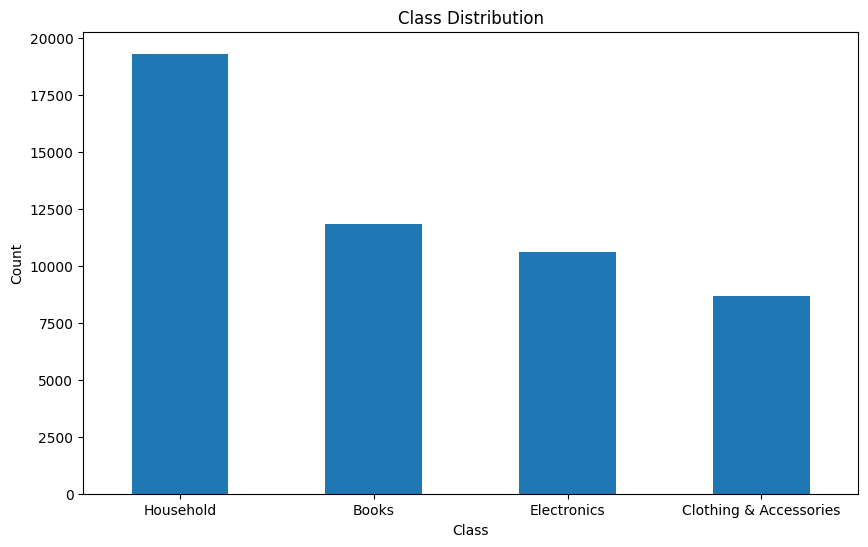

{'Books': 0, 'Clothing & Accessories': 1, 'Electronics': 2, 'Household': 3}
{0: 'Books', 1: 'Clothing & Accessories', 2: 'Electronics', 3: 'Household'}


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# Read CSV file
data = pd.read_csv("ecommerceDataset.csv", header=None)

# Create a graph showing the distribution of the target classes
type_counts = data[0].value_counts()
plt.figure(figsize=(10, 6))
type_counts.plot(kind="bar")
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.xticks(rotation=0)
plt.show()

# Remove rows with NaN values in the first and second columns
data = data.dropna(subset=[0, 1])
data = data.reset_index(drop=True)

y_data, x_data = data[0], data[1]
labels = set(y_data)
labels_int = {label: i for i, label in enumerate(sorted(labels))}
int_labels = {i: label for label, i in labels_int.items()}
y_data = np.array([labels_int[label] for label in y_data])

print(labels_int)
print(int_labels)

# Split the dataset into training and test sets (80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=1234, shuffle=True
)

## Prepare data for RNN and CNN

In [2]:
import tensorflow as tf

# Initialize TextVectorization layer
max_features = 120000
max_len=1000
vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=max_features, output_mode="int",
    output_sequence_length=max_len
)
vectorizer.adapt(x_train)

vocab_size = len(vectorizer.get_vocabulary())
print("Vocabulary size:", vocab_size)

x_train_tv = vectorizer(x_train)
x_test_tv = vectorizer(x_test)

2024-04-03 22:00:35.260808: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-03 22:00:37.138192: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-04-03 22:00:40.387397: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-03 22:00:40.593893: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-03 22:00:40.593984: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] co

Vocabulary size: 116531


## Sequential Model

Prepare data for Sequential Model

In [6]:
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf

# TF-IDF vectorizer returns a scipy sparse matrix which needs to be converted to a sparse tensor to be used with tensorflow models
# Convert sparse matrix to sparse tensor
def convert_sparse_matrix_to_sparse_tensor(sparse_matrix):
    coo = sparse_matrix.tocoo()
    indices = np.column_stack((coo.row, coo.col))
    values = coo.data
    shape = coo.shape
    return tf.sparse.SparseTensor(indices, values, shape)

nltk.download('popular')
stopwords = list(stopwords.words("english"))
vectorizer = TfidfVectorizer(stop_words=stopwords)

# Split the dataset into training and test sets (64% train, 16% val, 20% test)
x_train, x_val, y_train, y_val = train_test_split(
    x_data, y_data, test_size=0.2, random_state=1234, shuffle=True
)

x_train_tfidf = vectorizer.fit_transform(x_train)
x_val_tfidf = vectorizer.transform(x_val)
x_test_tfidf = vectorizer.transform(x_test)

# Convert to SparseTensor and Reorder SparseTensor for the model
x_train_sparse_tensor = convert_sparse_matrix_to_sparse_tensor(x_train_tfidf)
x_val_sparse_tensor = convert_sparse_matrix_to_sparse_tensor(x_val_tfidf)
x_test_sparse_tensor = convert_sparse_matrix_to_sparse_tensor(x_test_tfidf)

x_train_sparse_tensor = tf.sparse.reorder(x_train_sparse_tensor)
x_val_sparse_tensor = tf.sparse.reorder(x_val_sparse_tensor)
x_test_sparse_tensor = tf.sparse.reorder(x_test_sparse_tensor)

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

Build the Sequential model

In [7]:
import tensorflow as tf

seq_model = tf.keras.models.Sequential()
seq_model.add(tf.keras.layers.Dense(16, activation="relu", input_shape=(x_train_sparse_tensor.shape[1],)))
seq_model.add(tf.keras.layers.Dense(16, activation="relu"))
seq_model.add(tf.keras.layers.Dense(len(labels_int), activation="softmax"))

seq_model.compile(
    optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

Train the Sequential model

In [9]:
history = seq_model.fit(
    x_train_sparse_tensor,
    y_train,
    epochs=20,
    batch_size=512,
    validation_data=(x_val_sparse_tensor, y_val)
)

Epoch 1/20
79/79 [==============================] - 16s 150ms/step - loss: 1.1343 - accuracy: 0.5432 - val_loss: 0.8507 - val_accuracy: 0.7461
Epoch 2/20
79/79 [==============================] - 10s 123ms/step - loss: 0.6170 - accuracy: 0.8802 - val_loss: 0.4282 - val_accuracy: 0.9369
Epoch 3/20
79/79 [==============================] - 9s 107ms/step - loss: 0.3072 - accuracy: 0.9564 - val_loss: 0.2411 - val_accuracy: 0.9555
Epoch 4/20
79/79 [==============================] - 10s 123ms/step - loss: 0.1793 - accuracy: 0.9665 - val_loss: 0.1783 - val_accuracy: 0.9608
Epoch 5/20
79/79 [==============================] - 9s 119ms/step - loss: 0.1282 - accuracy: 0.9726 - val_loss: 0.1508 - val_accuracy: 0.9647
Epoch 6/20
79/79 [==============================] - 9s 108ms/step - loss: 0.0989 - accuracy: 0.9781 - val_loss: 0.1339 - val_accuracy: 0.9676
Epoch 7/20
79/79 [==============================] - 7s 83ms/step - loss: 0.0778 - accuracy: 0.9825 - val_loss: 0.1222 - val_accuracy: 0.9703
Epoc

Make predictions and show prediction results for the Sequential Model

316/316 [==============================] - 2s 5ms/step
                        precision    recall  f1-score   support

                 Books       0.97      0.98      0.98      2379
Clothing & Accessories       0.99      0.98      0.99      1710
           Electronics       0.98      0.97      0.97      2156
             Household       0.98      0.98      0.98      3840

              accuracy                           0.98     10085
             macro avg       0.98      0.98      0.98     10085
          weighted avg       0.98      0.98      0.98     10085


accuracy score:  0.9798710956866633

precision score:  0.9798834860759018

recall score:  0.9798710956866633

f1 score:  0.979867333882633


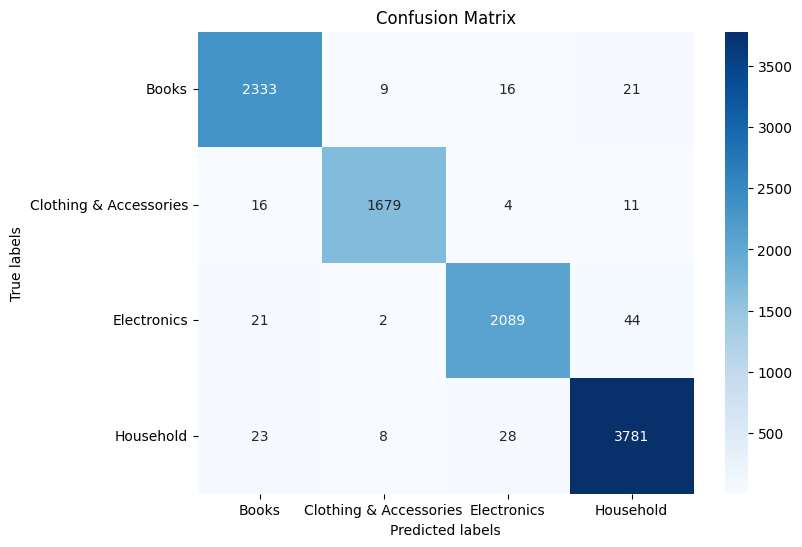

In [10]:
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
)

# make predictions on the test data
pred_prob = seq_model.predict(x_test_sparse_tensor)
pred = np.argmax(pred_prob, axis=1)

# Convert predicted integer labels to string labels
pred_labels = [int_labels[p] for p in pred]
y_test_labels = [int_labels[p] for p in y_test]

# Print Metrics(Need to handle multi class), Confusion Matrix and Classification Report
cm = confusion_matrix(y_test_labels, pred_labels)
print(classification_report(y_test_labels, pred_labels))
print("\naccuracy score: ", accuracy_score(y_test_labels, pred_labels))
print(
    "\nprecision score: ",
    precision_score(y_test_labels, pred_labels, average="weighted"),
)
print("\nrecall score: ", recall_score(y_test_labels, pred_labels, average="weighted"))
print("\nf1 score: ", f1_score(y_test_labels, pred_labels, average="weighted"))
# Create a heatmap for the confustion matrix
labels = labels_int.keys()
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="g")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

Sequential Model Evaluation

79/79 [==============================] - 0s 4ms/step - loss: 0.0997 - accuracy: 0.9799
[0.09968980401754379, 0.9798710942268372]


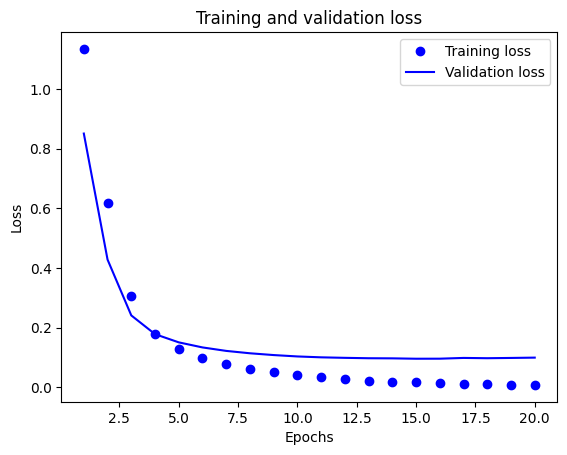

In [11]:
import matplotlib.pyplot as plt

losses_and_metrics = seq_model.evaluate(x_test_sparse_tensor, y_test, batch_size=128)
print(losses_and_metrics)

# plot the training and validation loss
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

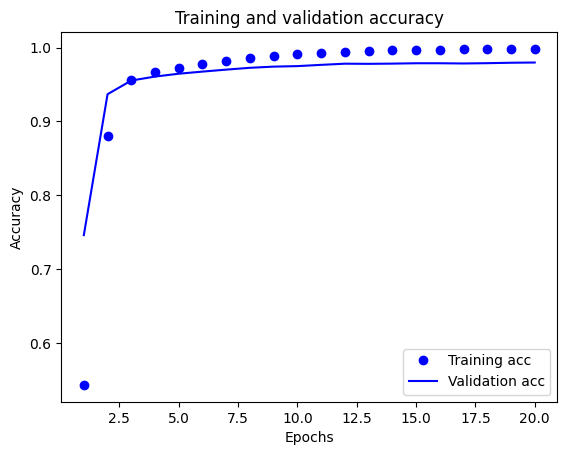

In [12]:
# plot the training and validation accuracy

plt.clf()  # clear

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

## RNN

Build the RNN model

In [ ]:
import tensorflow as tf

rnn_model = tf.keras.models.Sequential()
rnn_model.add(
    tf.keras.layers.Embedding(input_dim=max_features, output_dim=32, mask_zero=True)
)
rnn_model.add(tf.keras.layers.SimpleRNN(32))
rnn_model.add(tf.keras.layers.Dense(len(labels_int), activation="softmax"))

rnn_model.compile(
    optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

Train the RNN model

In [ ]:
history = rnn_model.fit(
    x_train_tv, y_train, epochs=10, batch_size=512, validation_split=0.2
)

Epoch 1/10
64/64 [==============================] - 1033s 16s/step - loss: 1.0121 - accuracy: 0.5820 - val_loss: 0.8122 - val_accuracy: 0.7362
Epoch 2/10
64/64 [==============================] - 1054s 16s/step - loss: 0.6668 - accuracy: 0.8224 - val_loss: 0.5413 - val_accuracy: 0.8699
Epoch 3/10
64/64 [==============================] - 1101s 17s/step - loss: 0.4583 - accuracy: 0.8976 - val_loss: 0.3537 - val_accuracy: 0.9271
Epoch 4/10
64/64 [==============================] - 1049s 16s/step - loss: 0.2808 - accuracy: 0.9402 - val_loss: 0.2581 - val_accuracy: 0.9482
Epoch 5/10
64/64 [==============================] - 1052s 16s/step - loss: 0.2071 - accuracy: 0.9540 - val_loss: 0.2097 - val_accuracy: 0.9582
Epoch 6/10
64/64 [==============================] - 1039s 16s/step - loss: 0.1519 - accuracy: 0.9653 - val_loss: 0.2214 - val_accuracy: 0.9509
Epoch 7/10
64/64 [==============================] - 1055s 16s/step - loss: 0.1105 - accuracy: 0.9752 - val_loss: 0.3531 - val_accuracy: 0.8990

Make predictions and show prediction results for the RNN model

316/316 [==============================] - 144s 454ms/step
[0 0 0 ... 0 0 2]
                        precision    recall  f1-score   support

                 Books       0.95      0.96      0.96      2379
Clothing & Accessories       0.98      0.96      0.97      1710
           Electronics       0.94      0.93      0.94      2156
             Household       0.96      0.97      0.96      3840

              accuracy                           0.96     10085
             macro avg       0.96      0.95      0.96     10085
          weighted avg       0.96      0.96      0.96     10085


accuracy score:  0.957263262270699

precision score:  0.9573483363101747

recall score:  0.957263262270699

f1 score:  0.9572484947183957


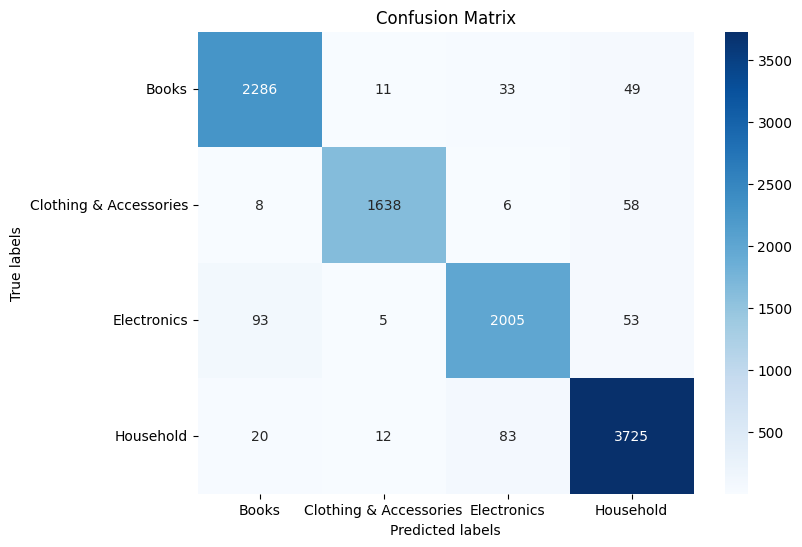

In [ ]:
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
)

# make predictions on the test data
pred_prob = rnn_model.predict(x_test_tv)
pred = np.argmax(pred_prob, axis=1)

print(pred)

# Convert predicted integer labels to string labels
pred_labels = [int_labels[p] for p in pred]
y_test_labels = [int_labels[p] for p in y_test]

# Print Metrics(Need to handle multi class), Confusion Matrix and Classification Report
cm = confusion_matrix(y_test_labels, pred_labels)
print(classification_report(y_test_labels, pred_labels))
print("\naccuracy score: ", accuracy_score(y_test_labels, pred_labels))
print(
    "\nprecision score: ",
    precision_score(y_test_labels, pred_labels, average="weighted", zero_division=1),
)
print("\nrecall score: ", recall_score(y_test_labels, pred_labels, average="weighted"))
print(
    "\nf1 score: ",
    f1_score(y_test_labels, pred_labels, average="weighted", zero_division=1),
)
# Create a heatmap for the confustion matrix
labels = labels_int.keys()
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="g")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

RNN Model Evaluation

79/79 [==============================] - 61s 775ms/step - loss: 0.1951 - accuracy: 0.9573
[0.19514940679073334, 0.9572632908821106]


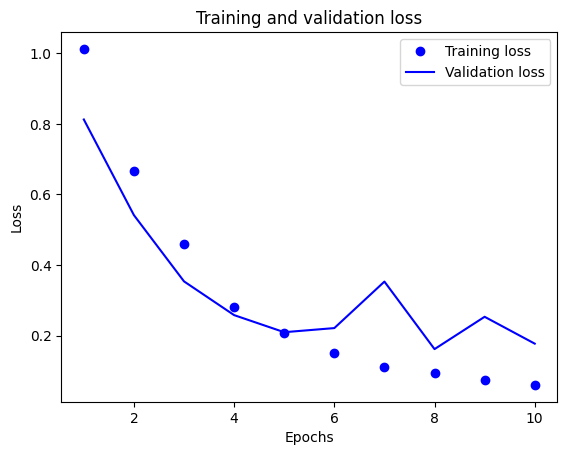

In [ ]:
import matplotlib.pyplot as plt

losses_and_metrics = rnn_model.evaluate(x_test_tv, y_test, batch_size=128)
print(losses_and_metrics)

# plot the training and validation loss
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

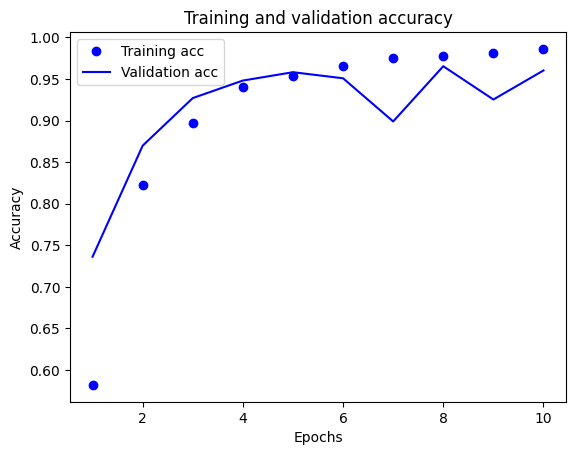

In [ ]:
# plot the training and validation accuracy

plt.clf()  # clear

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

## CNN

Build the CNN model

In [ ]:
import tensorflow as tf

cnn_model = tf.keras.models.Sequential()
cnn_model.add(
    tf.keras.layers.Embedding(input_dim=max_features, output_dim=128, mask_zero=True)
)
cnn_model.add(tf.keras.layers.Conv1D(32, 7, activation="relu"))
cnn_model.add(tf.keras.layers.MaxPooling1D(5))
cnn_model.add(tf.keras.layers.Conv1D(32, 7, activation="relu"))
cnn_model.add(tf.keras.layers.GlobalMaxPooling1D())
cnn_model.add(tf.keras.layers.Dense(len(labels_int), activation="softmax"))

cnn_model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

Train the CNN model

In [ ]:
history = cnn_model.fit(
    x_train_tv, y_train, epochs=20, batch_size=512, validation_split=0.2
)

Epoch 1/20
64/64 [==============================] - 52s 616ms/step - loss: 1.3484 - accuracy: 0.3664 - val_loss: 1.3230 - val_accuracy: 0.3925
Epoch 2/20
64/64 [==============================] - 34s 532ms/step - loss: 1.3204 - accuracy: 0.3813 - val_loss: 1.3061 - val_accuracy: 0.3925
Epoch 3/20
64/64 [==============================] - 32s 505ms/step - loss: 1.3050 - accuracy: 0.3813 - val_loss: 1.2896 - val_accuracy: 0.3925
Epoch 4/20
64/64 [==============================] - 33s 519ms/step - loss: 1.2832 - accuracy: 0.3982 - val_loss: 1.2618 - val_accuracy: 0.4267
Epoch 5/20
64/64 [==============================] - 35s 548ms/step - loss: 1.2457 - accuracy: 0.4289 - val_loss: 1.2138 - val_accuracy: 0.4602
Epoch 6/20
64/64 [==============================] - 33s 514ms/step - loss: 1.1822 - accuracy: 0.4754 - val_loss: 1.1372 - val_accuracy: 0.5321
Epoch 7/20
64/64 [==============================] - 32s 493ms/step - loss: 1.0891 - accuracy: 0.5618 - val_loss: 1.0345 - val_accuracy: 0.6117

Make predictions and show prediction results for the CNN model

316/316 [==============================] - 4s 10ms/step
[0 0 0 ... 0 0 2]
                        precision    recall  f1-score   support

                 Books       0.92      0.95      0.94      2379
Clothing & Accessories       0.96      0.92      0.94      1710
           Electronics       0.95      0.90      0.93      2156
             Household       0.93      0.96      0.94      3840

              accuracy                           0.94     10085
             macro avg       0.94      0.93      0.94     10085
          weighted avg       0.94      0.94      0.94     10085


accuracy score:  0.9371343579573624

precision score:  0.9376585541796639

recall score:  0.9371343579573624

f1 score:  0.9370476757461408


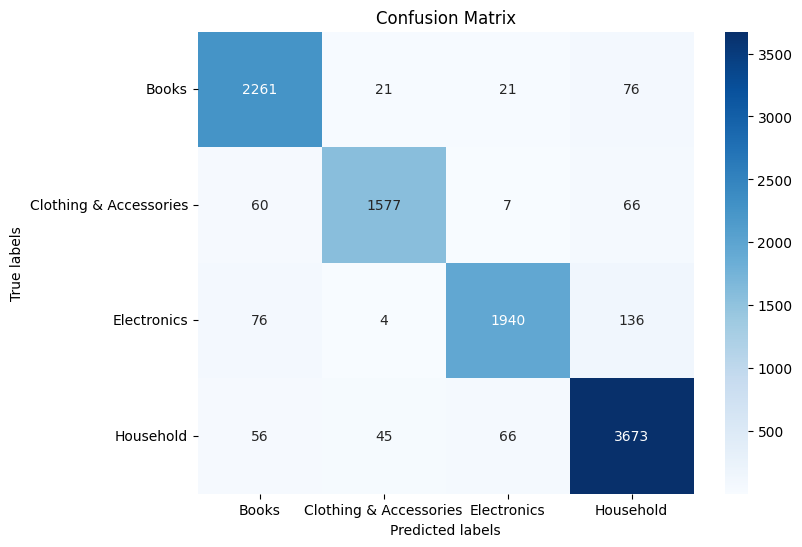

In [ ]:
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
)

# make predictions on the test data
pred_prob = cnn_model.predict(x_test_tv)
pred = np.argmax(pred_prob, axis=1)

print(pred)

# Convert predicted integer labels to string labels
pred_labels = [int_labels[p] for p in pred]
y_test_labels = [int_labels[p] for p in y_test]

# Print Metrics(Need to handle multi class), Confusion Matrix and Classification Report
cm = confusion_matrix(y_test_labels, pred_labels)
print(classification_report(y_test_labels, pred_labels))
print("\naccuracy score: ", accuracy_score(y_test_labels, pred_labels))
print(
    "\nprecision score: ",
    precision_score(y_test_labels, pred_labels, average="weighted", zero_division=1),
)
print("\nrecall score: ", recall_score(y_test_labels, pred_labels, average="weighted"))
print(
    "\nf1 score: ",
    f1_score(y_test_labels, pred_labels, average="weighted", zero_division=1),
)
# Create a heatmap for the confustion matrix
labels = labels_int.keys()
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="g")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

CNN Model evaluation

79/79 [==============================] - 5s 49ms/step - loss: 0.2581 - accuracy: 0.9371
[0.25813236832618713, 0.9371343851089478]


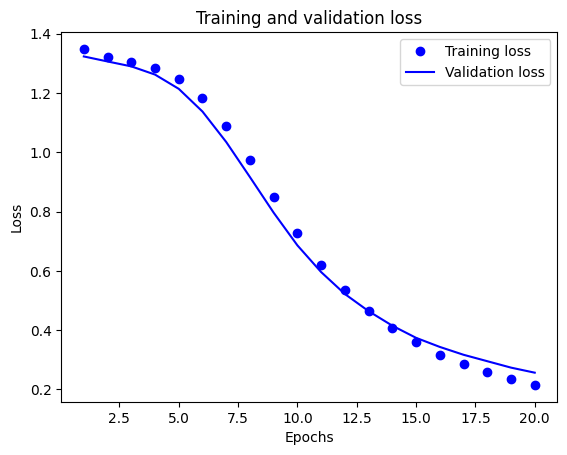

In [ ]:
import matplotlib.pyplot as plt

losses_and_metrics = cnn_model.evaluate(x_test_tv, y_test, batch_size=128)
print(losses_and_metrics)

# plot the training and validation loss
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

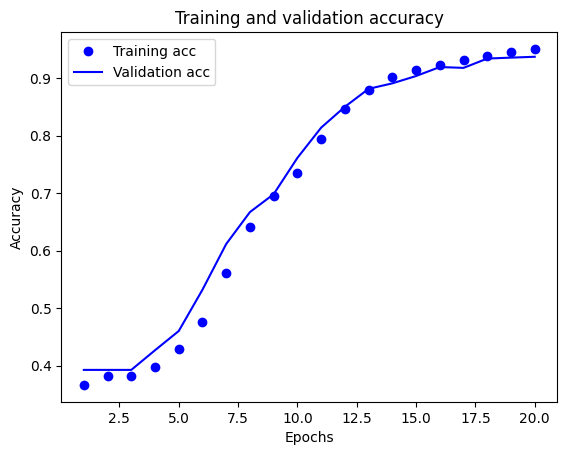

In [ ]:
# plot the training and validation accuracy

plt.clf()  # clear

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

## LSTM Model

Build the LSTM model

In [46]:
import tensorflow as tf
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Class weights to handle data imbalance
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=3, restore_best_weights=True
)

# build a model with LSTM
lstm_model = tf.keras.models.Sequential()
lstm_model.add(tf.keras.layers.Embedding(input_dim=max_features, output_dim=128, input_length=max_len))
lstm_model.add(tf.keras.layers.LSTM(128, return_sequences=True))
lstm_model.add(tf.keras.layers.Dropout(0.5))  # Added dropout for regularization because model has low accuracy
lstm_model.add(tf.keras.layers.LSTM(128))
lstm_model.add(tf.keras.layers.Dropout(0.5))
lstm_model.add(tf.keras.layers.Dense(len(labels_int), activation="softmax"))

lstm_model.compile(
    optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)


Train the LSTM model

In [47]:
history = lstm_model.fit(
    x_train_tv,
    y_train,
    epochs=20,
    batch_size=256,
    validation_split=0.2,
    callbacks=[early_stopping],
    class_weight=class_weights_dict
)

Epoch 1/20
127/127 [==============================] - 36s 247ms/step - loss: 1.3871 - accuracy: 0.2367 - val_loss: 1.3992 - val_accuracy: 0.2312
Epoch 2/20
127/127 [==============================] - 30s 239ms/step - loss: 1.3869 - accuracy: 0.2333 - val_loss: 1.3807 - val_accuracy: 0.2128
Epoch 3/20
127/127 [==============================] - 31s 243ms/step - loss: 1.3868 - accuracy: 0.2437 - val_loss: 1.3786 - val_accuracy: 0.3849
Epoch 4/20
127/127 [==============================] - 30s 234ms/step - loss: 1.3869 - accuracy: 0.2596 - val_loss: 1.3925 - val_accuracy: 0.2312
Epoch 5/20
127/127 [==============================] - 29s 227ms/step - loss: 1.3867 - accuracy: 0.2487 - val_loss: 1.3924 - val_accuracy: 0.2312
Epoch 6/20
127/127 [==============================] - 29s 231ms/step - loss: 1.3869 - accuracy: 0.2431 - val_loss: 1.3821 - val_accuracy: 0.3849


Make predictions and show prediction results for the LSTM model

316/316 [==============================] - 9s 26ms/step
[3 3 3 ... 3 3 3]
                        precision    recall  f1-score   support

                 Books       0.76      0.01      0.02      2379
Clothing & Accessories       0.00      0.00      0.00      1710
           Electronics       0.00      0.00      0.00      2156
             Household       0.38      1.00      0.55      3840

              accuracy                           0.38     10085
             macro avg       0.29      0.25      0.14     10085
          weighted avg       0.32      0.38      0.21     10085


accuracy score:  0.3821517104610808


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



precision score:  0.7077736101980088

recall score:  0.3821517104610808

f1 score:  0.21383354487965547


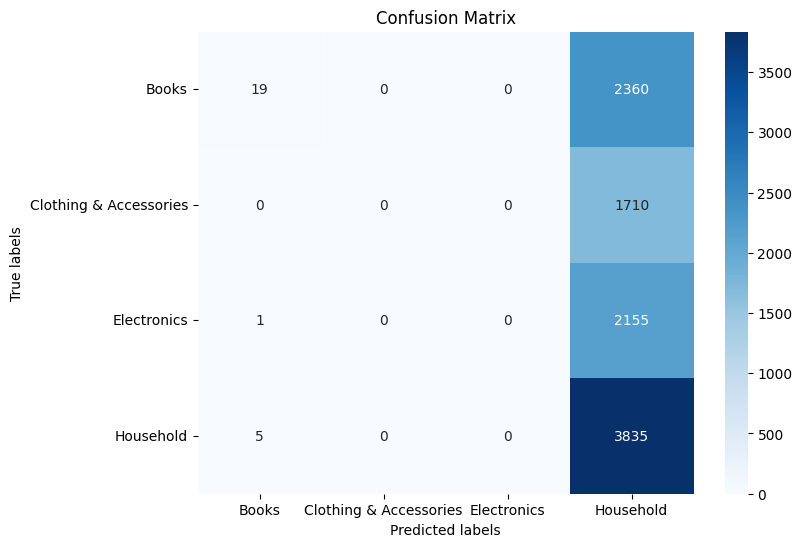

In [48]:
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
)

# make predictions on the test data
pred_prob = lstm_model.predict(x_test_tv)
pred = np.argmax(pred_prob, axis=1)

print(pred)

# Convert predicted integer labels to string labels
pred_labels = [int_labels[p] for p in pred]
y_test_labels = [int_labels[p] for p in y_test]

# Print Metrics(Need to handle multi class), Confusion Matrix and Classification Report
cm = confusion_matrix(y_test_labels, pred_labels)
print(classification_report(y_test_labels, pred_labels))
print("\naccuracy score: ", accuracy_score(y_test_labels, pred_labels))
print(
    "\nprecision score: ",
    precision_score(y_test_labels, pred_labels, average="weighted", zero_division=1),
)
print("\nrecall score: ", recall_score(y_test_labels, pred_labels, average="weighted"))
print(
    "\nf1 score: ",
    f1_score(y_test_labels, pred_labels, average="weighted", zero_division=1),
)
# Create a heatmap for the confustion matrix
labels = labels_int.keys()
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="g")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

LSTM Model evaluation

79/79 [==============================] - 4s 51ms/step - loss: 1.3786 - accuracy: 0.3822
[1.3786181211471558, 0.38215172290802]


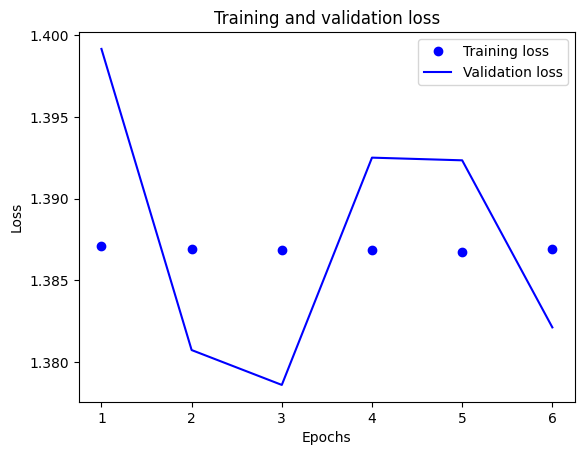

In [49]:
import matplotlib.pyplot as plt

losses_and_metrics = lstm_model.evaluate(x_test_tv, y_test, batch_size=128)
print(losses_and_metrics)

# plot the training and validation loss
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

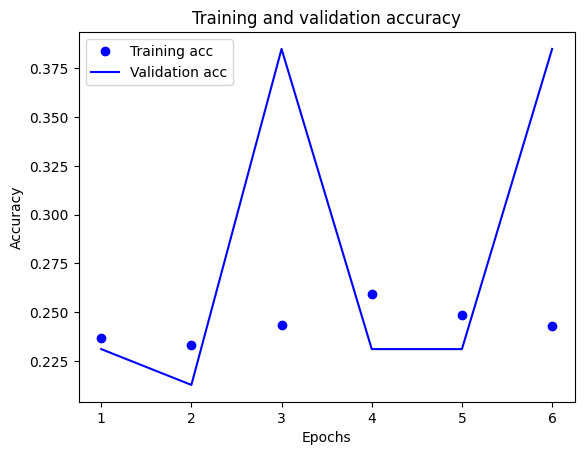

In [50]:
# plot the training and validation accuracy

plt.clf()  # clear

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

## GRU Model

Build the GRU model

In [4]:
import tensorflow as tf
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Class weights to handle data imbalance
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=3, restore_best_weights=True
)

# build a model with GRU
gru_model = tf.keras.models.Sequential()
gru_model.add(tf.keras.layers.Embedding(input_dim=max_features, output_dim=128))
gru_model.add(tf.keras.layers.GRU(128, return_sequences=True))
gru_model.add(tf.keras.layers.Dropout(0.5))  # Added dropout for regularization because model has low accuracy
gru_model.add(tf.keras.layers.GRU(128))
gru_model.add(tf.keras.layers.Dropout(0.5))
gru_model.add(tf.keras.layers.Dense(len(labels_int), activation="softmax"))

gru_model.compile(
    optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

Train the GRU model

In [5]:
history = gru_model.fit(
    x_train_tv,
    y_train,
    epochs=10,
    batch_size=256,
    validation_split=0.2,
    callbacks=[early_stopping],
    class_weight=class_weights_dict
)

Epoch 1/10


2024-04-03 22:02:19.501020: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


127/127 ━━━━━━━━━━━━━━━━━━━━ 29s 213ms/step - accuracy: 0.2503 - loss: 1.3880 - val_accuracy: 0.1730 - val_loss: 1.3863
Epoch 2/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 26s 208ms/step - accuracy: 0.2625 - loss: 1.3848 - val_accuracy: 0.2121 - val_loss: 1.3805
Epoch 3/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 28s 217ms/step - accuracy: 0.2584 - loss: 1.3889 - val_accuracy: 0.2312 - val_loss: 1.3866
Epoch 4/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 28s 217ms/step - accuracy: 0.2642 - loss: 1.3835 - val_accuracy: 0.1724 - val_loss: 1.3948
Epoch 5/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 27s 215ms/step - accuracy: 0.2423 - loss: 1.3846 - val_accuracy: 0.1734 - val_loss: 1.3898
Epoch 6/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 28s 217ms/step - accuracy: 0.2371 - loss: 1.3862 - val_accuracy: 0.2312 - val_loss: 1.3923


Make predictions and show prediction results for the GRU model

316/316 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step
[0 0 0 ... 0 0 0]
                        precision    recall  f1-score   support

                 Books       0.24      1.00      0.38      2379
Clothing & Accessories       0.00      0.00      0.00      1710
           Electronics       0.00      0.00      0.00      2156
             Household       0.00      0.00      0.00      3840

              accuracy                           0.24     10085
             macro avg       0.06      0.25      0.10     10085
          weighted avg       0.06      0.24      0.09     10085


accuracy score:  0.23589489340604858

precision score:  0.8197515073290025

recall score:  0.23589489340604858

f1 score:  0.09005037731273902


/home/ssj/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ssj/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ssj/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


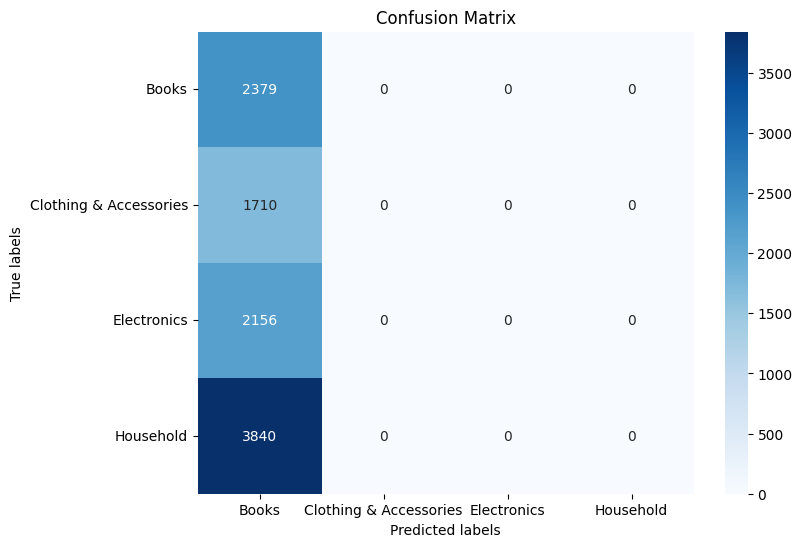

In [6]:
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
)

# make predictions on the test data
pred_prob = gru_model.predict(x_test_tv)
pred = np.argmax(pred_prob, axis=1)

print(pred)

# Convert predicted integer labels to string labels
pred_labels = [int_labels[p] for p in pred]
y_test_labels = [int_labels[p] for p in y_test]

# Print Metrics(Need to handle multi class), Confusion Matrix and Classification Report
cm = confusion_matrix(y_test_labels, pred_labels)
print(classification_report(y_test_labels, pred_labels))
print("\naccuracy score: ", accuracy_score(y_test_labels, pred_labels))
print(
    "\nprecision score: ",
    precision_score(y_test_labels, pred_labels, average="weighted", zero_division=1),
)
print("\nrecall score: ", recall_score(y_test_labels, pred_labels, average="weighted"))
print(
    "\nf1 score: ",
    f1_score(y_test_labels, pred_labels, average="weighted", zero_division=1),
)
# Create a heatmap for the confustion matrix
labels = labels_int.keys()
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="g")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

GRU Model evaluation

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.2352 - loss: 1.3866
[1.3864797353744507, 0.23589488863945007]


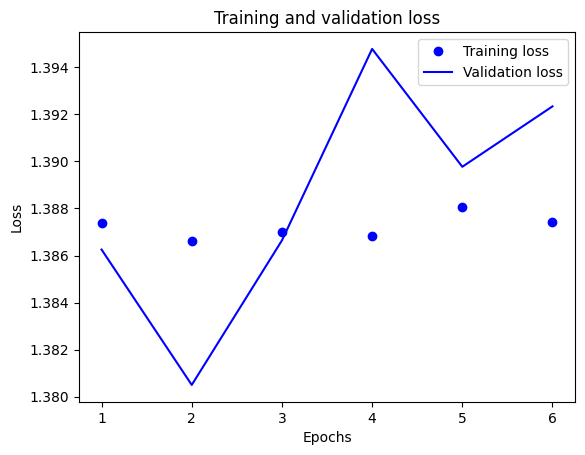

In [7]:
import matplotlib.pyplot as plt

losses_and_metrics = gru_model.evaluate(x_test_tv, y_test, batch_size=128)
print(losses_and_metrics)

# plot the training and validation loss
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

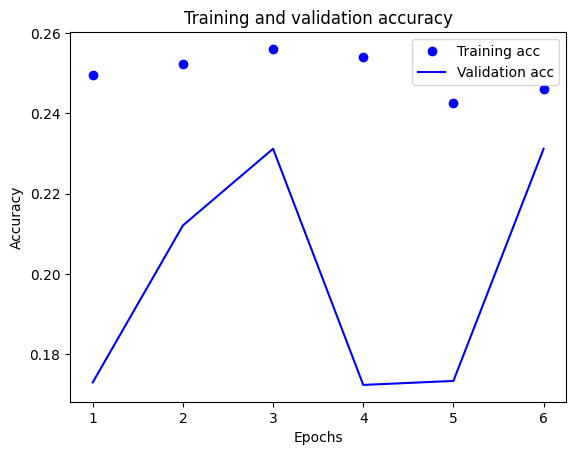

In [8]:
# plot the training and validation accuracy

plt.clf()  # clear

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

## Glove Pre-trained Embedding

Load pretrained embeddings

In [10]:
import os

path_to_glove_file = os.path.join(
    os.path.expanduser("~"), ".keras/datasets/glove.6B/glove.6B.100d.txt"
)

word_index = dict(zip(vectorizer.get_vocabulary(), range(vocab_size)))

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [23]:
num_tokens = vocab_size + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 45392 words (71139 misses)


Build the CNN model with pretrained embedding

In [21]:
import tensorflow as tf

embedding_layer = tf.keras.layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

int_sequences_input = tf.keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = tf.keras.layers.Conv1D(32, 7, activation="relu")(embedded_sequences)
x = tf.keras.layers.MaxPooling1D(5)(x)
x = tf.keras.layers.Conv1D(32, 7, activation="relu")(x)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
x = tf.keras.layers.Dense(len(labels_int), activation="softmax")(x)
preds = tf.keras.layers.Dense(len(labels_int), activation="softmax")(x)
em_cnn_model = tf.keras.Model(int_sequences_input, preds)

Train the model

In [17]:
em_cnn_model.compile(
    loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["acc"]
)
em_cnn_model.fit(x_train_tv, y_train, batch_size=128, epochs=20, validation_split=0.2)

Epoch 1/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 25s 89ms/step - acc: 0.7556 - loss: 0.6038 - val_acc: 0.7509 - val_loss: 0.6284
Epoch 2/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - acc: 0.7729 - loss: 0.5718 - val_acc: 0.7538 - val_loss: 0.6153
Epoch 3/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 24s 93ms/step - acc: 0.7731 - loss: 0.5494 - val_acc: 0.7564 - val_loss: 0.5920
Epoch 4/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 22s 89ms/step - acc: 0.7805 - loss: 0.5262 - val_acc: 0.7569 - val_loss: 0.5781
Epoch 5/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - acc: 0.7793 - loss: 0.5119 - val_acc: 0.7551 - val_loss: 0.5821
Epoch 6/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - acc: 0.7823 - loss: 0.4955 - val_acc: 0.7572 - val_loss: 0.5595
Epoch 7/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - acc: 0.7846 - loss: 0.4847 - val_acc: 0.7581 - val_loss: 0.5398
Epoch 8/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 19s 76ms/step - acc: 0.7812 - loss: 0.4731 - val_acc: 0.7594 - val_loss: 0.5265
Epoch 9/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 

Make predictions and show prediction results for the Glove Embedding CNN model

316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
[0 0 0 ... 0 0 0]
                        precision    recall  f1-score   support

                 Books       0.51      0.97      0.67      2379
Clothing & Accessories       0.97      0.97      0.97      1710
           Electronics       0.00      0.00      0.00      2156
             Household       0.96      0.96      0.96      3840

              accuracy                           0.76     10085
             macro avg       0.61      0.73      0.65     10085
          weighted avg       0.65      0.76      0.69     10085


accuracy score:  0.7604362915220625

precision score:  0.8637017493645252

recall score:  0.7604362915220625


/home/ssj/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ssj/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ssj/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



f1 score:  0.6883799954726545


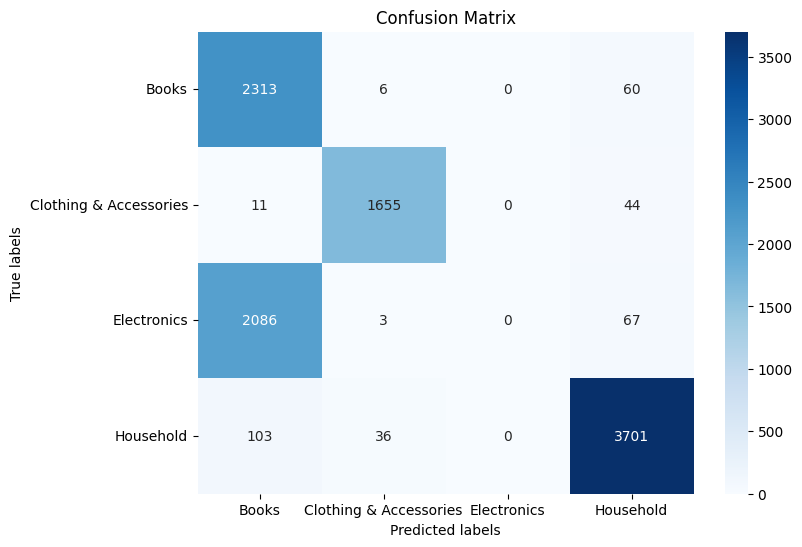

In [18]:
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
)

# make predictions on the test data
pred_prob = em_cnn_model.predict(x_test_tv)
pred = np.argmax(pred_prob, axis=1)

print(pred)

# Convert predicted integer labels to string labels
pred_labels = [int_labels[p] for p in pred]
y_test_labels = [int_labels[p] for p in y_test]

# Print Metrics(Need to handle multi class), Confusion Matrix and Classification Report
cm = confusion_matrix(y_test_labels, pred_labels)
print(classification_report(y_test_labels, pred_labels))
print("\naccuracy score: ", accuracy_score(y_test_labels, pred_labels))
print(
    "\nprecision score: ",
    precision_score(y_test_labels, pred_labels, average="weighted", zero_division=1),
)
print("\nrecall score: ", recall_score(y_test_labels, pred_labels, average="weighted"))
print(
    "\nf1 score: ",
    f1_score(y_test_labels, pred_labels, average="weighted", zero_division=1),
)
# Create a heatmap for the confustion matrix
labels = labels_int.keys()
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="g")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

Glove Embedding CNN Model evaluation

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.7605 - loss: 0.4723
[0.4723975360393524, 0.7604362964630127]


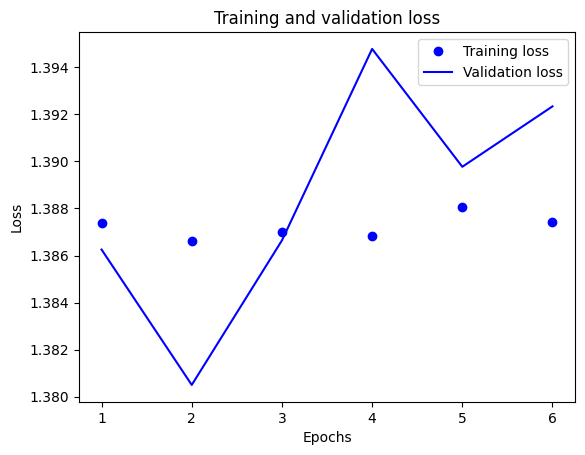

In [19]:
import matplotlib.pyplot as plt

losses_and_metrics = em_cnn_model.evaluate(x_test_tv, y_test, batch_size=128)
print(losses_and_metrics)

# plot the training and validation loss
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

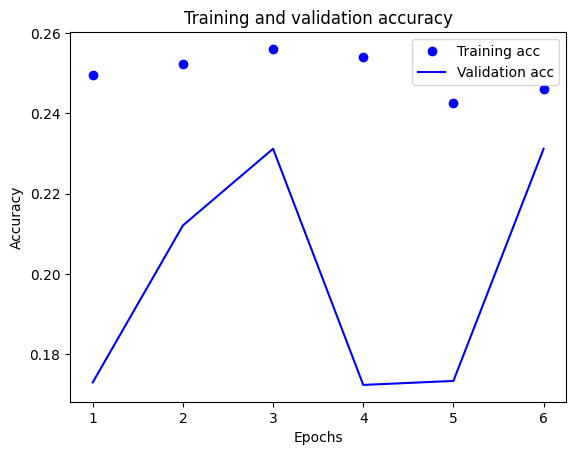

In [20]:
# plot the training and validation accuracy

plt.clf()  # clear

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

# Analysis (Report)

In this Notebook, I examined multiple Deep Neural Network architectures for Text classification problem. My dataset is taken from Kaggle which contains about 50,000 rows and each row contains a e-Commerce product description and its product category, namely Household, Books, Electronics, and Closthing & Accessories.

Initially, I tried a sequential Neural Network model with 3 layers. The preprocessing for this model is done separately from other models because a Tf-Idf bag-of-words model seems to work pretty good for this text classification task. I used the sciki-learn TfIdfVectorizer to convert text data to a vectorized form and then convert it to sparse tensors. The sparse tensors need to be reordered as well. With the preprocessing done, I proceeded to train the model and the results were pretty good. The predictions of the model had an accuracy score close to 98%. The model was evaluated further and its plots are shown.

Secondly, I used a Simple Recurrent Neural Network model with 3 layers. The preprocessing for this and all other models was done using Keras' TextVectorization. The RNN model performs well and has close to 96% accuracy but this model took a long while to train even with GPU support. The model evaluation plots for this model is also shown in its respective section. With a long training time and little-to-no gain in performance I believe we should look towards other Neural Network architectures for the desired performance.

Then, I used a Convolutional Neural Network model with 6 layers. The CNN model performs reasonably well and has a short training time. This was the main reason to choose CNN for another model with a pretrained embedding layer, discussed further. The predictions from the CNN model have a accuracy score close to 94%. The evaluation plots for this CNN model are shown in the CNN subsection of this notebook.

Then, I moved on to use LSTM and GRU for our text classification task, but both these models seem to perform horribly for our task. Both these models always predict only 1 class for each row in the training set. Although, the accuracy scores are 38% and 23% for LSTM and GRU respectively, it can be observed in the confusion matrix plot that LSTM always predicts Household class and GRU always predicts Books. I tried experimenting with early stopping, dropouts to avoid overfitting. I also tried multiple different architectures for both these models where I changed the number of nodes in each layer and introduced multiple layers as well, but to no avail. The LSTM and GRU models perform very poorly for this task. Maybe this could be improved but I tried a lot of things and failed. The model prediction details & evaluation plots are shown in their respective sections.

Lastly, I used the Glove pre-trained embedding layer with the CNN model to get a better performance, but even this model has a glaring problem. This model seems to work well with Household and Clothing & Accessories classes but it could not learn the difference between Books and Electronics. Thus, this model has a low accuracy. Maybe if I changed the CNN model architecture, I could have got a better performing model. This model has an accuracy score of 76%. Further prediction details and evaluation plots are shown in its respective section. 
